In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [118]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/bengkod/UASbengkod/ObesityDataSet.csv"
df = pd.read_csv(dataset_path)
df_clean = df.copy()

print("Lima baris pertama:\n", df.head())

Lima baris pertama:
   Age  Gender Height Weight        CALC FAVC FCVC NCP  SCC SMOKE CH2O  \
0  21  Female   1.62     64          no   no    2   3   no    no    2   
1  21  Female   1.52     56   Sometimes   no    3   3  yes   yes    3   
2  23    Male    1.8     77  Frequently   no    2   3   no    no    2   
3  27    Male    1.8     87  Frequently   no    3   3   no    no    2   
4  22    Male   1.78   89.8   Sometimes   no    2   1   no    no    2   

  family_history_with_overweight FAF TUE       CAEC                 MTRANS  \
0                            yes   0   1  Sometimes  Public_Transportation   
1                            yes   3   0  Sometimes  Public_Transportation   
2                            yes   2   1  Sometimes  Public_Transportation   
3                             no   2   0  Sometimes                Walking   
4                             no   0   0  Sometimes  Public_Transportation   

            NObeyesdad  
0        Normal_Weight  
1        Normal_Weigh

In [119]:
print("\nInformasi dataset:")
print(df.info())


Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Age                             2097 non-null   object
 1   Gender                          2102 non-null   object
 2   Height                          2099 non-null   object
 3   Weight                          2100 non-null   object
 4   CALC                            2106 non-null   object
 5   FAVC                            2100 non-null   object
 6   FCVC                            2103 non-null   object
 7   NCP                             2099 non-null   object
 8   SCC                             2101 non-null   object
 9   SMOKE                           2106 non-null   object
 10  CH2O                            2105 non-null   object
 11  family_history_with_overweight  2098 non-null   object
 12  FAF                         

In [120]:
print("\nDeskripsi statistik:\n", df.describe())


Deskripsi statistik:
          Age Gender Height Weight       CALC  FAVC  FCVC   NCP   SCC SMOKE  \
count   2097   2102   2099   2100       2106  2100  2103  2099  2101  2106   
unique  1394      3   1562   1518          5     3   808   637     3     3   
top       18   Male    1.7     80  Sometimes   yes     3     3    no    no   
freq     124   1056     58     58       1386  1844   647  1183  1997  2054   

        CH2O family_history_with_overweight   FAF   TUE       CAEC  \
count   2105                           2098  2103  2102       2100   
unique  1263                              3  1186  1130          5   
top        2                            yes     0     0  Sometimes   
freq     441                           1705   404   552       1747   

                       MTRANS      NObeyesdad  
count                    2105            2111  
unique                      6               7  
top     Public_Transportation  Obesity_Type_I  
freq                     1572             3

In [121]:
print("\nMissing values tiap kolom:\n", df.isnull().sum())
print("\nJumlah data duplikat:", df.duplicated().sum())


Missing values tiap kolom:
 Age                               14
Gender                             9
Height                            12
Weight                            11
CALC                               5
FAVC                              11
FCVC                               8
NCP                               12
SCC                               10
SMOKE                              5
CH2O                               6
family_history_with_overweight    13
FAF                                8
TUE                                9
CAEC                              11
MTRANS                             6
NObeyesdad                         0
dtype: int64

Jumlah data duplikat: 18


In [122]:
print("\nJumlah nilai unik tiap kolom:\n", df.nunique())


Jumlah nilai unik tiap kolom:
 Age                               1394
Gender                               3
Height                            1562
Weight                            1518
CALC                                 5
FAVC                                 3
FCVC                               808
NCP                                637
SCC                                  3
SMOKE                                3
CH2O                              1263
family_history_with_overweight       3
FAF                               1186
TUE                               1130
CAEC                                 5
MTRANS                               6
NObeyesdad                           7
dtype: int64


In [123]:
# Cek nilai unik dan missing values
print("Missing Values:")
print(df.isnull().sum())
print("Unique Values:")
print(df.nunique())
print("Checking '?' values:")
print((df == "?").sum())

Missing Values:
Age                               14
Gender                             9
Height                            12
Weight                            11
CALC                               5
FAVC                              11
FCVC                               8
NCP                               12
SCC                               10
SMOKE                              5
CH2O                               6
family_history_with_overweight    13
FAF                                8
TUE                                9
CAEC                              11
MTRANS                             6
NObeyesdad                         0
dtype: int64
Unique Values:
Age                               1394
Gender                               3
Height                            1562
Weight                            1518
CALC                                 5
FAVC                                 3
FCVC                               808
NCP                                637
SCC            

In [124]:
# Replace '?' with NaN in the entire dataframe
df.replace('?', float('nan'), inplace=True)

# Convert columns to numeric, coercing errors to NaN
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')

# Handle missing values by filling NaNs with the mean of each column (or you can drop rows)
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Now, apply scaling
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [125]:
print("Missing Values:")
print(df.isnull().sum())
print("Unique Values:")
print(df.nunique())
print("Checking '?' values:")
print((df == "?").sum())

Missing Values:
Age                                0
Gender                            22
Height                             0
Weight                             0
CALC                              20
FAVC                              22
FCVC                               0
NCP                                0
SCC                               18
SMOKE                             13
CH2O                               0
family_history_with_overweight    23
FAF                                0
TUE                                0
CAEC                              18
MTRANS                            12
NObeyesdad                         0
dtype: int64
Unique Values:
Age                               1394
Gender                               2
Height                            1562
Weight                            1518
CALC                                 4
FAVC                                 2
FCVC                               808
NCP                                637
SCC            

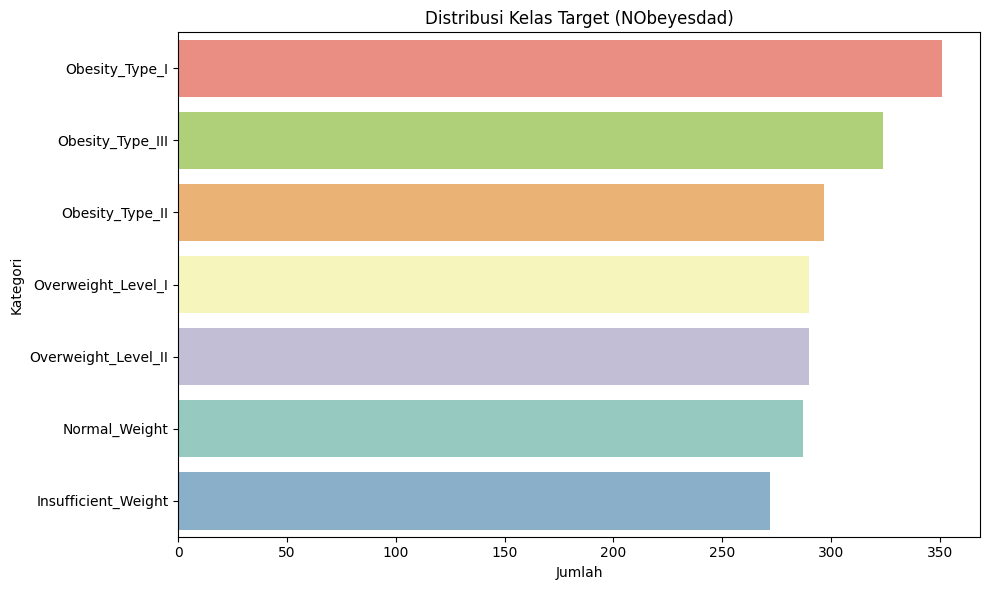

In [126]:
# Visualisasi distribusi kelas target
plt.figure(figsize=(10, 6))
sns.countplot(y='NObeyesdad', data=df, order=df['NObeyesdad'].value_counts().index, palette='Set3', hue='NObeyesdad', legend=False)
plt.title('Distribusi Kelas Target (NObeyesdad)')
plt.xlabel('Jumlah')
plt.ylabel('Kategori')
plt.tight_layout()
plt.show()

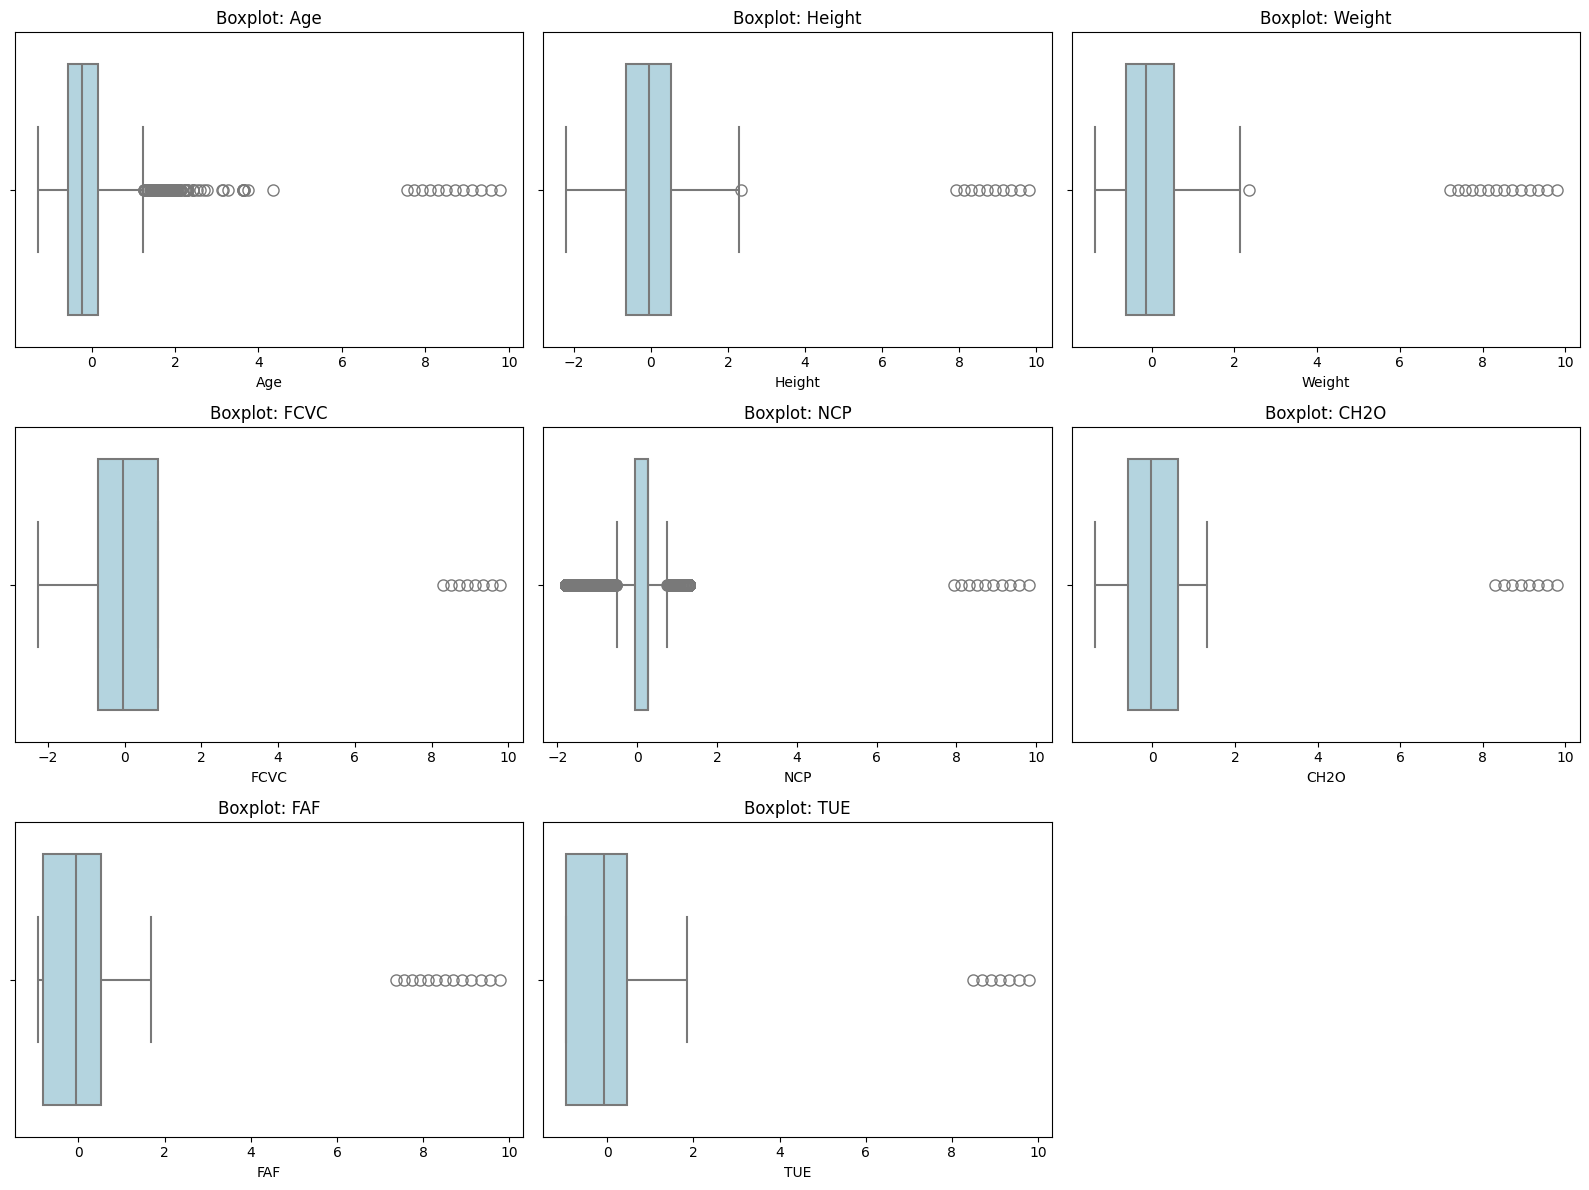

In [127]:
# Visualize Boxplot for Outliers
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)  # Arrange boxplots in a 3x3 grid
    sns.boxplot(x=col, data=df, color='lightblue', fliersize=8, linewidth=1.5)  # Increase fliersize for better visibility
    plt.title(f'Boxplot: {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

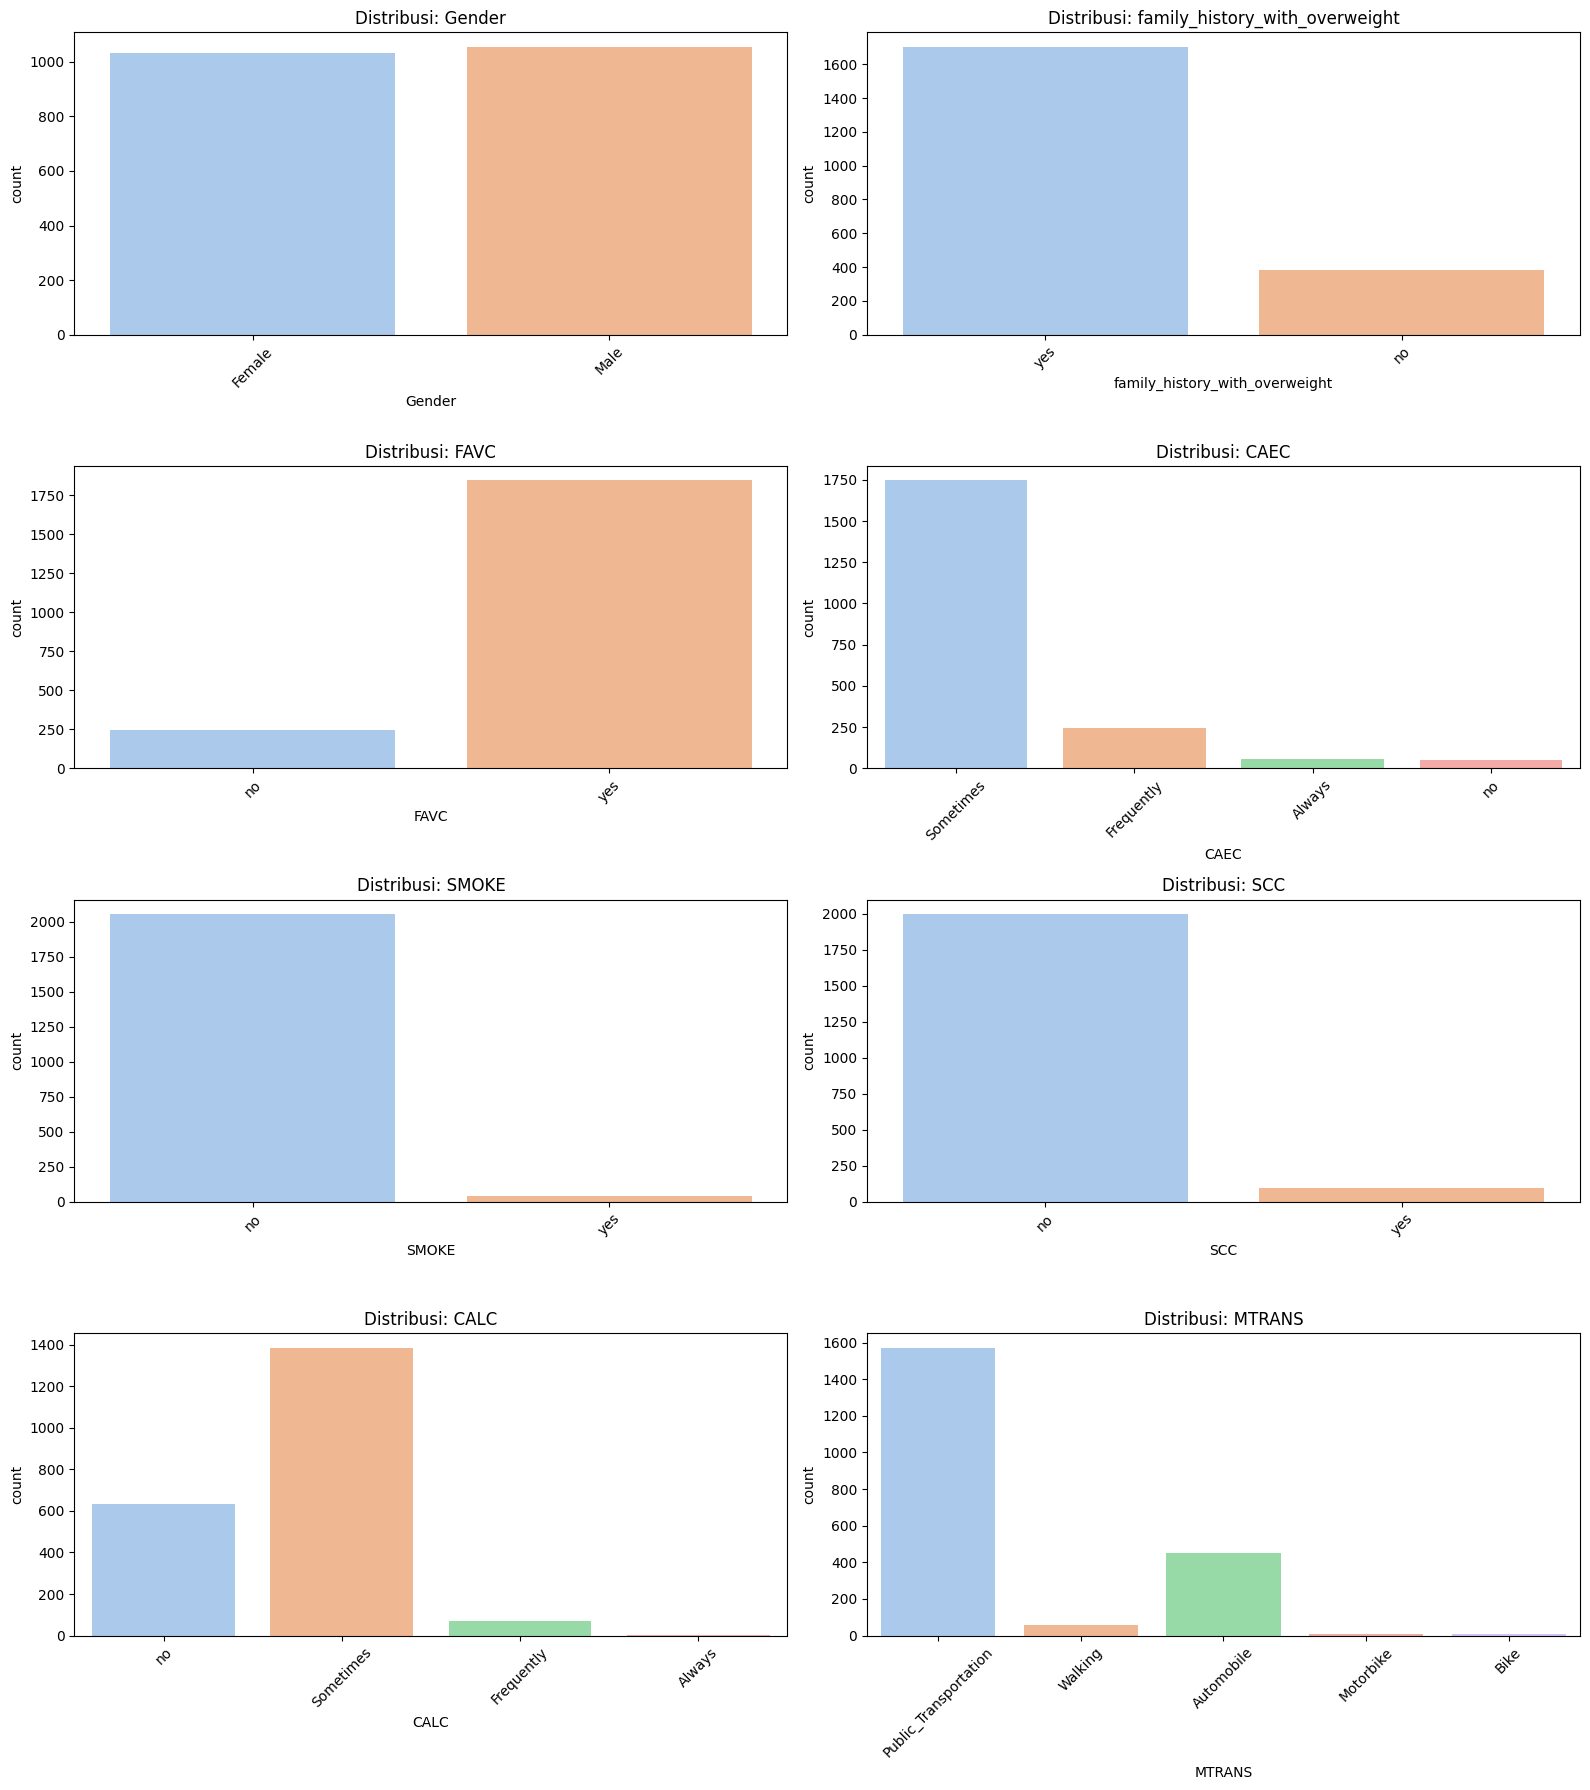

In [128]:
# Visualisasi kolom kategorikal dan biner
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
                    'SCC', 'CALC', 'MTRANS']

plt.figure(figsize=(16, 18))
for i, col in enumerate(categorical_cols):
    plt.subplot(4, 2, i+1)
    sns.countplot(data=df, x=col, hue=col, palette='pastel', legend=False)
    plt.title(f'Distribusi: {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()